In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import seaborn as sns

train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')

print(train.shape,test.shape)

#get the target variable to y and drop it from input features
y=train['Survived']
train=train.drop(['Survived'],axis=1)

(891, 12) (418, 11)


Feature engineering includes filling missing(0) or null values with intermediate ones, Titles were replaced because certain classes were more likely to be preferred over others when rescuing. Deck is extracted from 1st letter of Cabin which indicates certain decks had a better chances of survival over others (such as upper deck people were more likely to get off first), Hot encoding certain columns to convert data to Numerical or Boolean values.

In [12]:
def preprocess_data(df, title_mapping=None, is_train=True):
    df = df.copy()

    df = df.drop(['Ticket'], axis=1)
    
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked']=df['Embarked'].fillna(df['Embarked'].mode()[0])
    df["Title"] = df["Name"].str.extract(r' ([A-Za-z]+)\.')

    title_replacements = {
        "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
        "Lady": "Rare", "Countess": "Rare", "Capt": "Rare",
        "Col": "Rare", "Don": "Rare", "Dr": "Rare",
        "Major": "Rare", "Rev": "Rare", "Sir": "Rare",
        "Jonkheer": "Rare", "Dona": "Rare"
    }
    df['Title'] = df['Title'].replace(title_replacements)
    
    if is_train:
        title_mapping = df['Title'].value_counts().to_dict() 
    df['Title'] = df['Title'].map(title_mapping) 
    df['Title'] = df['Title'].fillna(0)

    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    
    df['Deck'] = df['Cabin'].astype(str).str[0] 
    df["HasCabin"] = df["Cabin"].notnull().astype(int) 
    

    df = pd.get_dummies(df, columns=['Embarked', 'Sex', 'Deck'], drop_first=False)
    df = df.drop(['Name', 'Cabin'], axis=1)
    
    
    if is_train:
        return df, title_mapping
    else:
        return df

In [13]:
X, title_mapping = preprocess_data(train, is_train=True)
test = preprocess_data(test, title_mapping, is_train=False)

test = test.reindex(columns=X.columns, fill_value=0)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(test)


LeakyRelu was tried after trial and error with Relu to counter stalling if input is negative,
essentially it was a small performance gain over ReLU

In [14]:
model = keras.Sequential([
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dropout(0.4),
    
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dropout(0.4),

    layers.Dense(32),
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid') 
])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), 
          epochs=100, batch_size=32, callbacks=[early_stopping])

# class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
# class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# model.fit(X_train, y_train, 
#           validation_data=(X_valid, y_valid), 
#           epochs=100, 
#           batch_size=32, 
#           callbacks=[early_stopping], 
#           class_weight=class_weight_dict)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4912 - loss: 0.8534 - val_accuracy: 0.6760 - val_loss: 0.6586
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5538 - loss: 0.7503 - val_accuracy: 0.7207 - val_loss: 0.6338
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5833 - loss: 0.7395 - val_accuracy: 0.7151 - val_loss: 0.6127
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6221 - loss: 0.6587 - val_accuracy: 0.7318 - val_loss: 0.5952
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6807 - loss: 0.6412 - val_accuracy: 0.7542 - val_loss: 0.5793
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6720 - loss: 0.6235 - val_accuracy: 0.7542 - val_loss: 0.5613
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6989 - loss: 0.6363 - val_accuracy: 0.7542 - val_loss: 0.5461
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6748 - loss: 0.6055 - val_accuracy: 0.7542 - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(array([0, 1]), array([96, 83]))
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Accuracy: 0.8399
Validation Accuracy: 0.8045
Precision: 0.7349
Recall: 0.8243
F1 Score: 0.7771
(891, 11)
(418, 23)


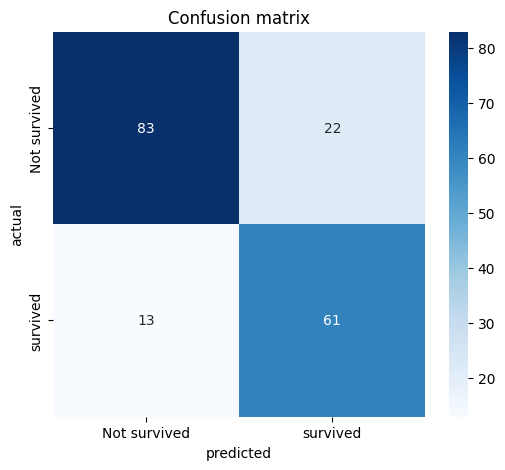

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


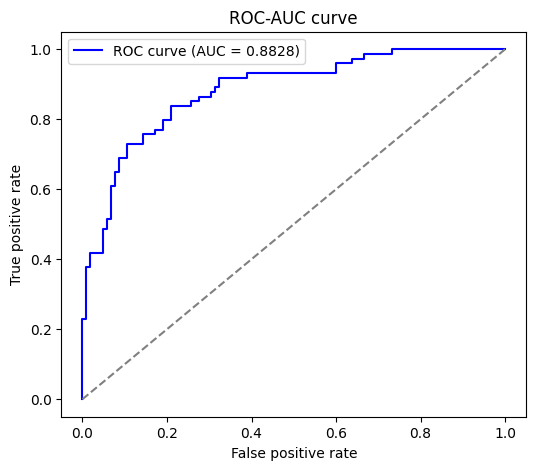

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


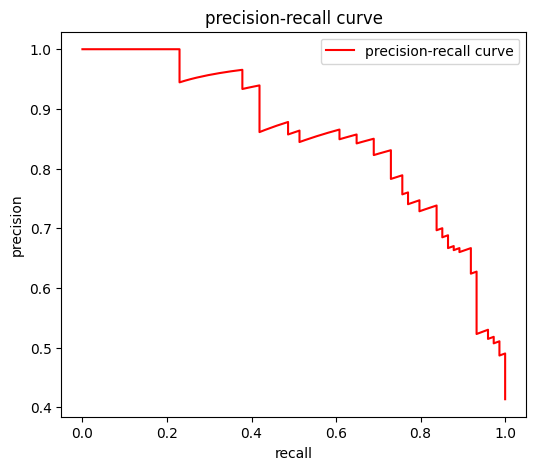

In [18]:

y_train_pred = (model.predict(X_train_scaled) > 0.47).astype(int)
y_valid_pred = (model.predict(X_valid_scaled)>0.47).astype(int)
y_test_pred = (model.predict(X_test_scaled)>0.47).astype(int)

print(np.unique(y_valid_pred, return_counts=True))

accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)


y_train_pred = (model.predict(X_train_scaled) > 0.47).astype(int)
train_acc = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print(train.shape)
print(test.shape)

cm = confusion_matrix(y_valid, y_valid_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not survived", "survived"], yticklabels=["Not survived", "survived"])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("Confusion matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_valid, model.predict(X_valid_scaled))
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--")  # Random classifier
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC-AUC curve")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_valid, model.predict(X_valid_scaled))


plt.figure(figsize=(6,5))
plt.plot(recall, precision, color="red", label="precision-recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision-recall curve")
plt.legend()
plt.show()

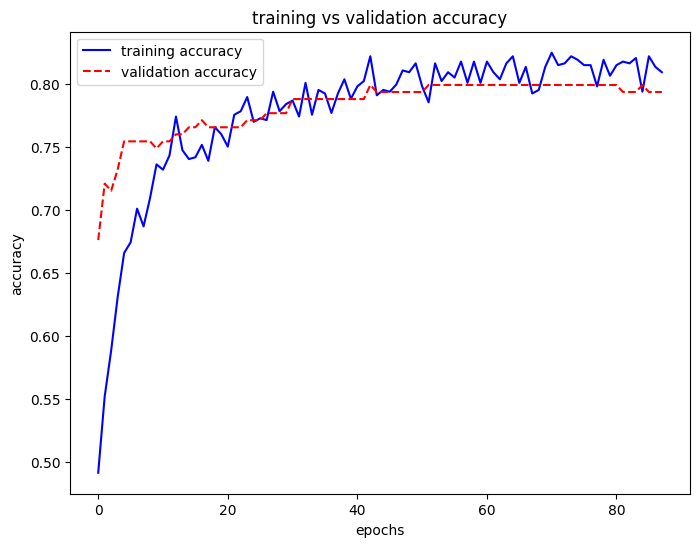

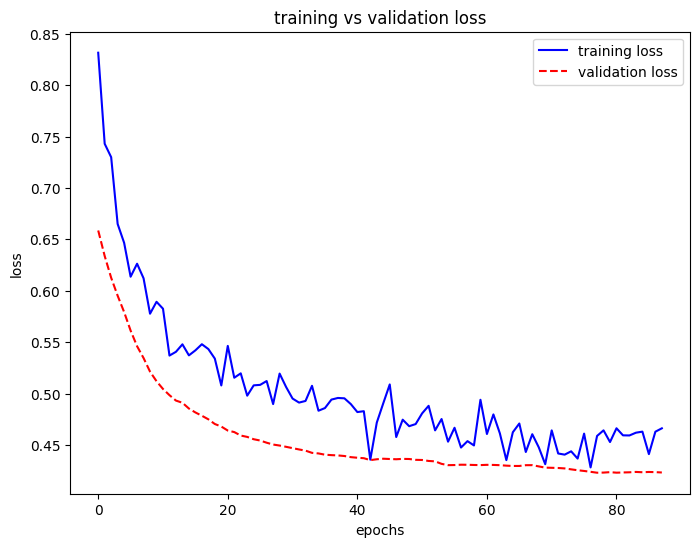

In [19]:
history_dict = history.history


plt.figure(figsize=(8,6))
plt.plot(history_dict['accuracy'], label='training accuracy', color='blue')
plt.plot(history_dict['val_accuracy'], label='validation accuracy', color='red', linestyle='dashed')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training vs validation accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(history_dict['loss'], label='training loss', color='blue')
plt.plot(history_dict['val_loss'], label='validation loss', color='red', linestyle='dashed')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training vs validation loss')
plt.legend()
plt.show()

In [17]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],  
    "Survived": y_test_pred.flatten()
})

submission.to_csv("submission.csv", index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
